<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller: Reconocimiento facial con K-medias y K-medoides

En este caso-taller vamos a aplicar K-medias y K-medoides para agrupar rostros de indiviudos. Utilizaremos la base de datos conocida como Caras Olivetti. Esta base contiene diez imágenes diferentes de  40 personas distintas. Para algunas personas, las imágenes se tomaron en diferentes momentos, variando la iluminación, las expresiones faciales (ojos abiertos/cerrados, sonriendo/sin sonreír) y los detalles faciales (gafas/sin gafas). Todas las imágenes fueron tomadas contra un fondo homogéneo oscuro con los sujetos en una posición frontal erguida (con tolerancia a algún movimiento lateral). Esta base viene incluida dentro de la libraría `scikit-learn` y fueron provistas por T&T Laboratories Cambridge para que la comunidad académica la utilice para la evaluación de modelos predictivos. 

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos 

Los datos pueden ser bajados directamente utilizando la librería `scikit-learn`,  la función que le permite hacer esto es `fetch_olivetti_faces`. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd #pueden explorar con sklearn
from sklearn.decomposition import TruncatedSVD

import os
os.environ["OMP_NUM_THREADS"] = '2'


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix
from sklearn.decomposition import PCA
import itertools
from sklearn_extra.cluster import KMedoids 

In [2]:
# Utilice este espacio para escribir el código.
from sklearn.datasets import fetch_olivetti_faces

olivetti_faces = fetch_olivetti_faces(data_home="data")

(Utilice este espacio para describir su procedimiento).

### 2.  Análisis preliminar 

#### 2.1. Describa los contenidos de la base de datos, tenga en cuenta que debe detallar los elementos, la dimensión de la base, y la dimensión de las imágenes. 

In [3]:
print(olivetti_faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

La informacion esta almacenada como diccionario en la cuales se tienen los elementos

- **data**: tiene la forma de n x f en donde:
    - **n** es la cantidad total de imagenes obtenidas por la carga de informacion
    - **f** es la imagen correspondiente al dato $n_i$ reformada de tal manera que queda como un vector 1 x k , donde k es igual a la multiplicacion de (h*w) donde h es la altura de la imagen y w es el ancho de la misma (ambas medidas en pixeles), k tambien se interpreta como el numero total de pixeles en la imagen

- **images**: tiene almacenados los datos en la forma n x 1, sin embargo este primer elemento es una matriz de la forma (h x w)

- **target**: array de tamaño n x 1 que contiene la codificacion numerica que indica de quien es la cara, tiene valores desde 0 hasta 39

In [4]:
(n,k) = olivetti_faces["data"].shape
print("tamaño total de los datos: {n}".format(n=n))
print("tamaño del array con la imagen en formato plano (total de pixeles en la imagen): {k}".format(k=k))

tamaño total de los datos: 400
tamaño del array con la imagen en formato plano (total de pixeles en la imagen): 4096


In [5]:
(n,h,w) = olivetti_faces["images"].shape
print("tamaño total de los datos: {n}".format(n=n))
print("altura de la imagen en píxeles: {h}".format(h=h))
print("ancho de la imagen en píxeles: {w}".format(w=w))
print("total de pixeles en la imagen: {t}".format(t=h*w))

tamaño total de los datos: 400
altura de la imagen en píxeles: 64
ancho de la imagen en píxeles: 64
total de pixeles en la imagen: 4096


Como es de esperarse la multiplicacion de **h** y **w** es igual a el segundo componente del array **data** (4096)

a continuacion para tratar mejor los datos las variables relacionadas con el **target** se van a transformar a un dataframe

In [6]:
df_images = pd.DataFrame(olivetti_faces["data"])

target = olivetti_faces["target"]
target = pd.DataFrame(target, columns=['target'])
df_images = df_images.join(target)

print("numero de imagenes descargadas:{n}".format(n=df_images.shape[0]))
print("cantidad de personas con imagenes en el dataset: {p}".format(p=df_images["target"].unique().shape[0]))

numero de imagenes descargadas:400
cantidad de personas con imagenes en el dataset: 40


El dataset como enuncia en la descricpion contiene 10 imagenes de cada una de las 40 personas, y contiene una columna target que indentifica de forma numerica a quien pertenece la imagen

#### 2.2. Genere una figura con una imágen de cada uno de los individuos

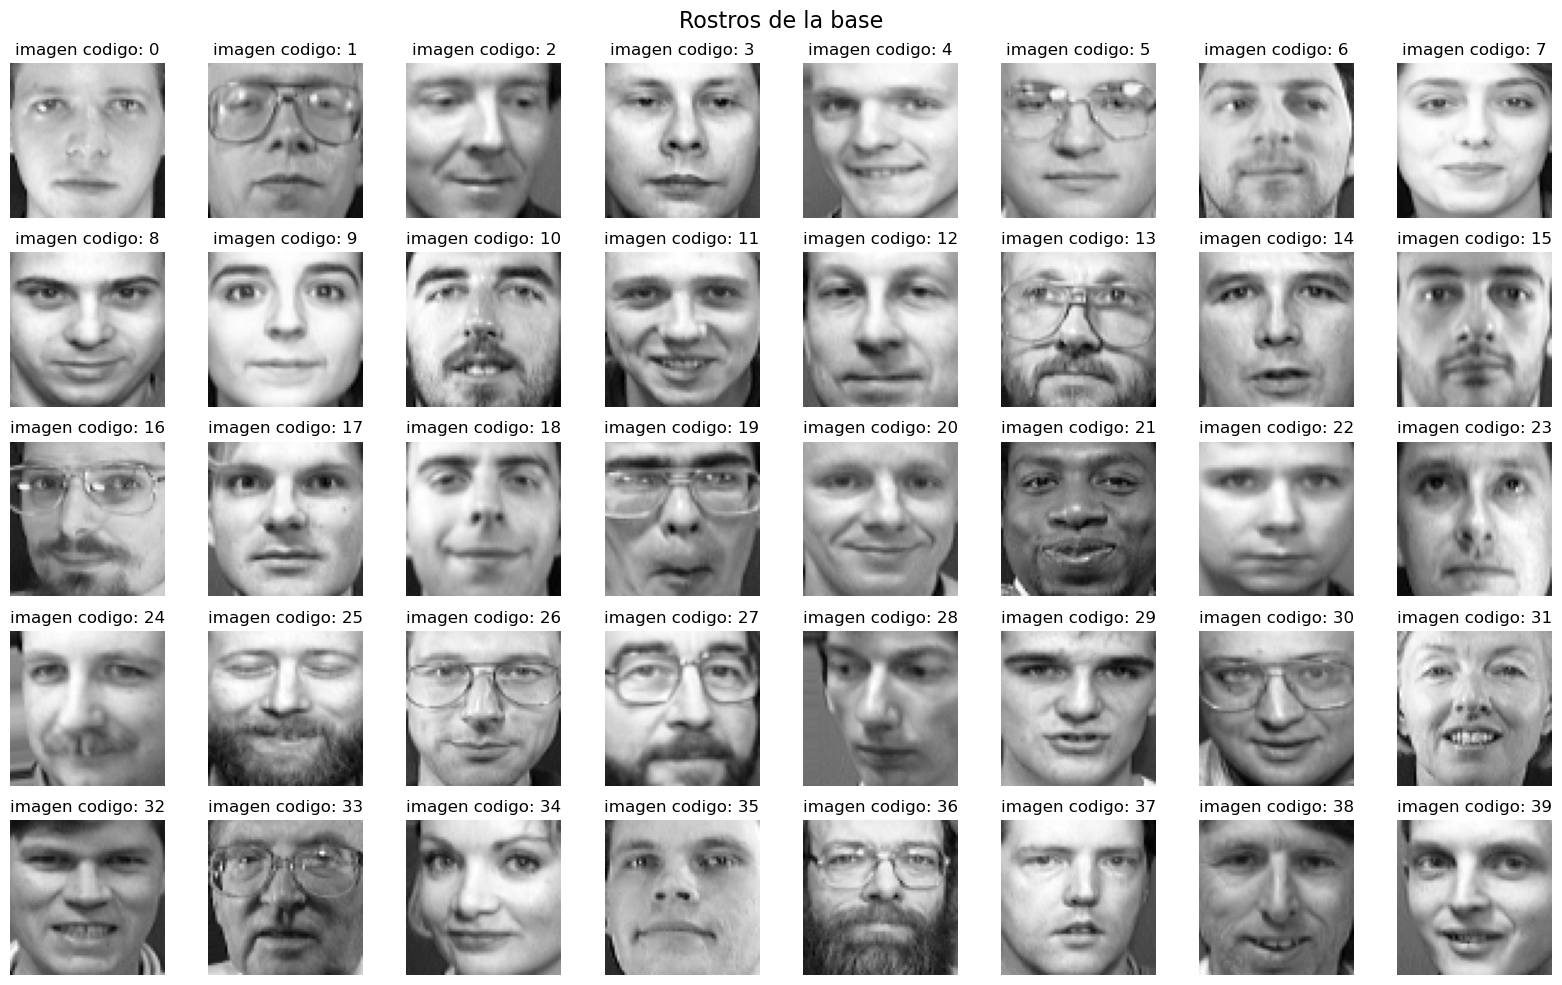

In [7]:
# cantidad de imagenes que se quieren graficar
num_images = len(df_images["target"].unique())

# Determinar el tamaño del grid de imagenes
rows = 5
cols = int(np.ceil(num_images/rows))

fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
axes = axes.flatten()

# loop desde 0 hasta le tamaño de las imagenes filtradas
for i in df_images["target"].unique():
    # Filtro para identificar las imagenes con marca igual a i
    c = df_images["target"] == i

    ax = axes[i]
    #traer la imagen i de la persona cuyo valor en targuet es igual a i
    # me parecio traer la imagen i%10 realmente en .iloc[] se puede colocar cualquier numero entre [0,39]
    ax.imshow(df_images[c].iloc[i%10,:-1].to_numpy().reshape(h,w), cmap='gray') 
    # eliminar axis
    ax.set_title("imagen codigo: {}".format(i))
    ax.axis('off')  

# eliminar axis de las imagenes vacias
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

fig.suptitle("Rostros de la base", fontsize=16)
plt.tight_layout()
plt.show()

Se generan las 40 imagenes correspondientes a las 40 personas de la base, en ella se ven diferentes personas, de diferentes sexos, con distintos encuadres y expresiones, ademas de porsupuesto rasgos faciales

#### 2.3. Transforme las imágenes en un data frame donde cada columna contiene los valores estandarizados del nivel de gris en la imagen y una columna con la etiqueta de cada imagen. 

In [8]:
scaler = StandardScaler()
df_images_scaled = pd.DataFrame(scaler.fit_transform(df_images.iloc[:,:-1]))

# convertir los datos de targuet en un dataframe
target = olivetti_faces["target"]
target = pd.DataFrame(target, columns=['target'])
# unir el targuet con la base de datos original, se asume que los targuet estan 
# ordenados de la misma manera que el dataset de entrada
df_images_scaled = df_images_scaled.join(target)

print("valores descriptivos base original \n")
display(df_images.describe().loc[["count","mean","std"],:])
print("valores descriptivos base estandarizada \n")
display(df_images_scaled.describe().loc[["count","mean","std"],:])

valores descriptivos base original 



,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.400134,0.434236,0.476281,0.518481,0.554845,0.588729,0.621426,0.647510,0.664814,0.676591,...,0.367221,0.363027,0.355506,0.340196,0.338657,0.335909,0.321415,0.313647,0.310455,19.500000
std,0.180695,0.189504,0.194742,0.193313,0.188593,0.178481,0.167109,0.155024,0.147616,0.143583,...,0.181861,0.181611,0.188709,0.186088,0.189256,0.195280,0.187842,0.183616,0.180635,11.557853


valores descriptivos base estandarizada 



,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,400.000000,...,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,400.000000,400.000000
mean,1.907349e-08,-9.536743e-09,1.907349e-08,9.536743e-09,1.907349e-08,9.536743e-09,1.907349e-08,0.000000,-1.907349e-08,0.000000,...,-4.768371e-09,4.768371e-09,-9.536743e-09,-1.192093e-09,1.430511e-08,-9.536743e-09,9.536743e-09,0.000000,0.000000,19.500000
std,1.001252e+00,1.001253e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252,1.001252e+00,1.001252,...,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001253e+00,1.001252,1.001252,11.557853


Se muestran las medidas de la media y la desviacion estandar para los datos sin estandarizar y luego de ser estandarizados, validando asi que para cada pixel de la imagen se han estandarizado para tener media 0 y desviacion estandar igual al 1

### 3. Clasificando de forma no supervisada

En esta sección trataremos de clasificar las imágenes de los individuos de forma no supervisada. Para ello utilizaremos los algoritmos de k-medias y k-medoides. Dado que sabemos que el dataset consta de 40 personas diferentes, utilizaremos esta información para pedirle a los algoritmos que encuentren k=40 clusters y examinaremos su precisión.


#### 3.1. Implemente k-medias sobre los datos estandarizados en el punto anterior. Al implementar utilice  `random_state=123` y `n_init=10`. (Esto puede tomar mucho tiempo y requerir mucho RAM, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))

In [9]:
kmeans = KMeans(n_clusters = 40, random_state = 123, n_init=10)
kpredict = kmeans.fit_predict(df_images_scaled.iloc[:,:-1])

c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


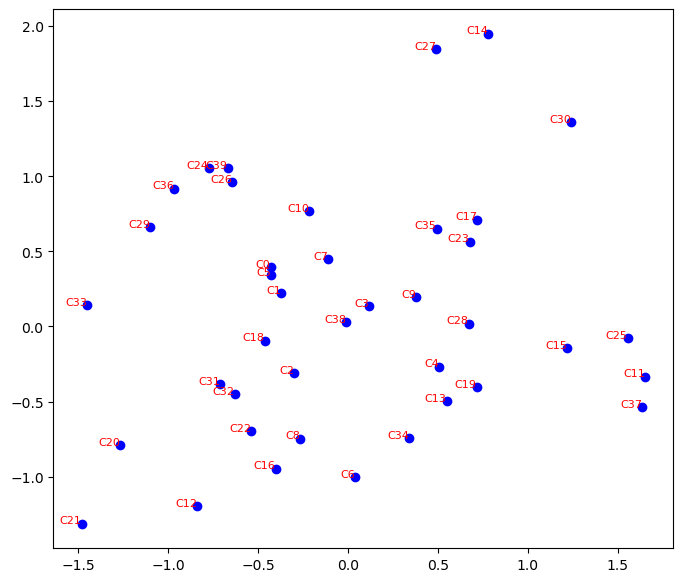

In [10]:
# Plotting Centroides
centroides = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize=(8,7))
#g_centroides = plt.scatter(centroides[:,0], centroides[:,1], color = "blue", label = "Centroides")
plt.scatter(centroides[:,0], centroides[:,1000], color = "blue", label = "Centroides")
# Add labels to the centroids
for i, centroid in enumerate(centroides):
    ax.text(centroid[0], centroid[1000], f'C{i}', fontsize=8, ha='right', color='red')
plt.show()

In [11]:
def homologar_llave_cluster_llave_dataset(df, col_homologar):
    '''
        Funcion para obtener la moda de los cluster originiales en los cluster predichos

        parametros:
            df: datos con la informacion de las imagenes y los valores reales
            col_homologar: nombre de la columna para la cual se quiere conocer la moda de los valores reales

        retorno:
            diccionario cuyas llaves son los valores de los clusters identificados por el algoritmo y los valores corresponden a las etiquetas originales
    '''
    

    # cantidad de etiquetas del targuet contenida en cada cluster
    info_cluster = df.groupby([col_homologar,"target"])[[0]].count().sort_values(by=[col_homologar,0], ascending = False)
    
    # seleccionar la moda
    homologa_pred_vs_cluster = info_cluster.groupby(col_homologar).head(1).reset_index()[[col_homologar,"target"]]

    # retorna diccionario para una mejor homologacion
    dict_homologador = dict(zip(homologa_pred_vs_cluster[col_homologar],homologa_pred_vs_cluster["target"]))
    return dict_homologador

In [12]:
metodo = "kmeans"
nombre_metodo = "predict_{}".format(metodo)

# asignacion de las predicciones
df_images_scaled[nombre_metodo] = kpredict
# aplicar el homologador
dict_homologa_kmeans = homologar_llave_cluster_llave_dataset(df_images_scaled,nombre_metodo)
# asignacion de nuevos
df_images_scaled[nombre_metodo] = df_images_scaled[nombre_metodo].map(dict_homologa_kmeans)

El resultado del algoritmo Kmeans es una asignacion de los datos a uno de los K clusters, por lo que es necesario realizazr una interpretacion de aquellos clusters, en este caso particular como se cuenta con las etiquetas reales de las fotos, se puede determinar cual es la moda para cada cluster y asi determinar que el cluster $K_i$ corresponde a las fotos del individuo(moda).

Con otras fuentes de informacion es probable que para esto sea necesario analizar los valores medios del centroide identificado en cada cluster.

#### 3.2. Evalúe la precisión del algoritmo para agrupar las imágenes de los individuos. 

In [13]:
dict_silhouette = {}
dict_precision = {}
dict_class_report = {}
dict_confusion_matrix = {}

In [14]:
# Creacion de las variables verdaderas y las predichas para el calculo de metricas
y_true = df_images_scaled.loc[:,"target"]
y_pred = df_images_scaled.loc[:,nombre_metodo]

In [15]:
columns_y = ["target",nombre_metodo]
data = df_images_scaled.drop(columns=columns_y)
silhouette = silhouette_score(data, y_pred)
dict_silhouette[metodo] = silhouette
print(silhouette)

0.12113329


In [16]:
precision = precision_score(y_true, y_pred, average="micro")
dict_precision[metodo] = precision
print(precision)

0.6625


In [17]:
report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)["weighted avg"]
dict_class_report[metodo] = report
print(report)

{'precision': 0.6115353717284495, 'recall': 0.6625, 'f1-score': 0.6193079220808415, 'support': 400.0}


<Axes: >

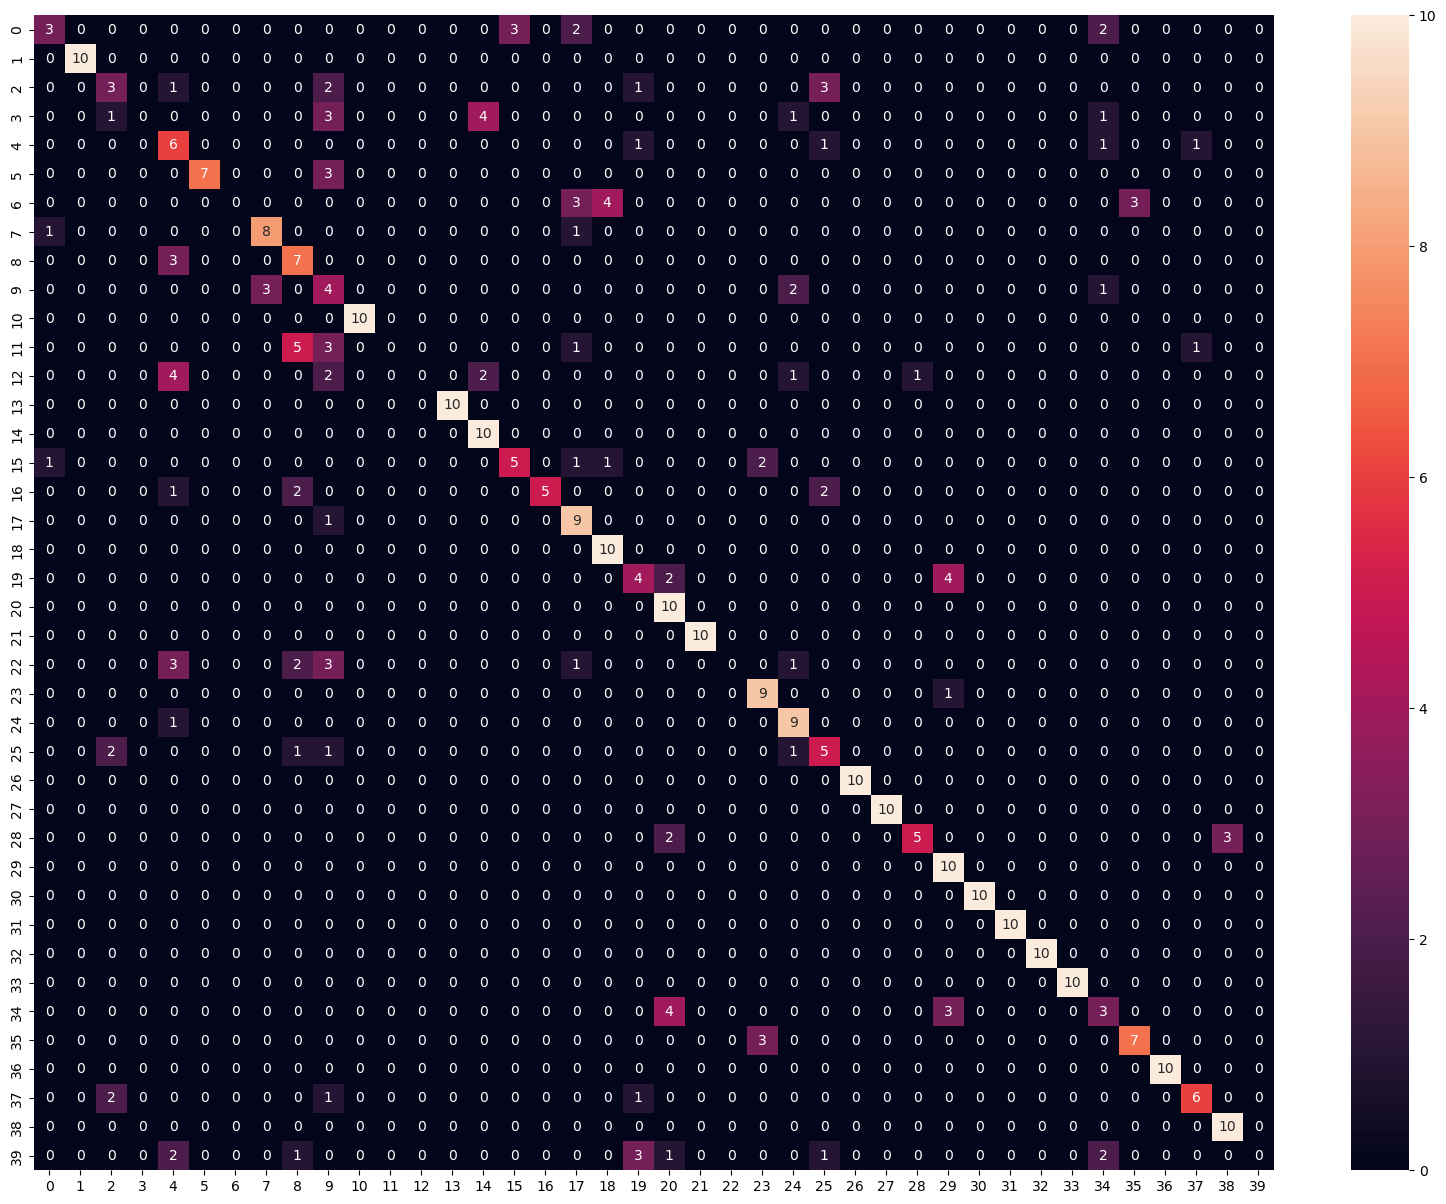

In [18]:
fig,ax = plt.subplots(figsize=(20,15))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, ax=ax)

In [19]:
def graficar_imagenes_individuo_original(i):
    num_images = sum(df_images["target"] == i)

    # Determinar el tamaño del grid de imagenes
    cols = 5
    rows = int(np.ceil(num_images/cols))

    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    axes = axes.flatten()

    
    for n in np.arange(0,num_images):
        # Filtro para identificar las imagenes con marca igual a i
        c = df_images["target"] == i

        ax = axes[n]
        #traer la imagen i de la persona cuyo valor en targuet es igual a i
        # me parecio traer la imagen i%10 realmente en .iloc[] se puede colocar cualquier numero entre [0,39]
        ax.imshow(df_images[c].iloc[n,:-1].to_numpy().reshape(h,w), cmap='gray') 
        # eliminar axis
        ax.set_title("imagen codigo: {}".format(i))
        ax.axis('off')  

        # eliminar axis de las imagenes vacias
        for j in range(i + 1, rows * cols):
            axes[j].axis('off')

    fig.suptitle("Rostros del individuo {}".format(i), fontsize=16)
    plt.tight_layout()
    plt.show()

def graficar_imagenes_individuo_predicho(i,col_preds):
    
    c = df_images_scaled[col_preds] == i
    index_img = df_images_scaled[c].index.values

    num_images = len(index_img)

    if num_images > 0:

        # Determinar el tamaño del grid de imagenes
        cols = 5
        rows = int(np.ceil(num_images/cols))

        fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
        axes = axes.flatten()


        for n, idx in enumerate(index_img):
            # Filtro para identificar las imagenes con marca igual a i
            
            ax = axes[n]
            #traer la imagen i de la persona cuyo valor en targuet es igual a i
            # me parecio traer la imagen i%10 realmente en .iloc[] se puede colocar cualquier numero entre [0,39]
            ax.imshow(df_images.iloc[idx,:-1].to_numpy().reshape(h,w), cmap='gray') 
            # eliminar axis
            ax.set_title("imagen codigo: {}".format(df_images_scaled["target"][idx]))
            ax.axis('off')  

            # eliminar axis de las imagenes vacias
            for j in range(i + 1, rows * cols):
                axes[j].axis('off')

        fig.suptitle("Predicciones rostros del individuo {}".format(i), fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("no existen imagenes con predicciones para el rostro {}".format(i))

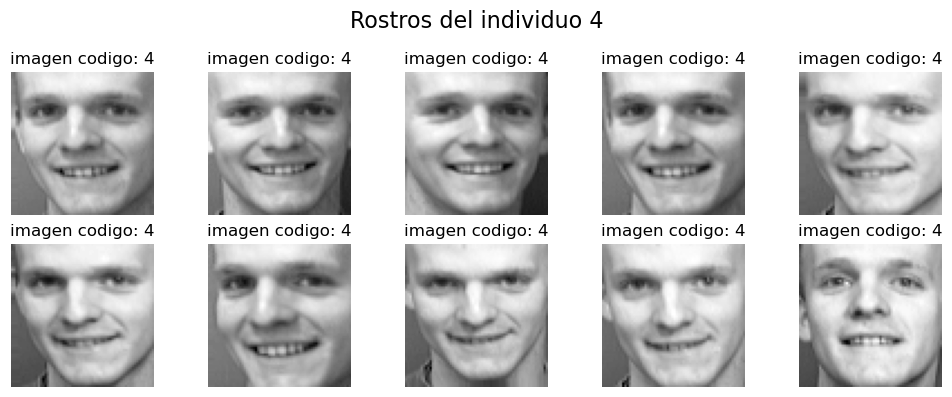

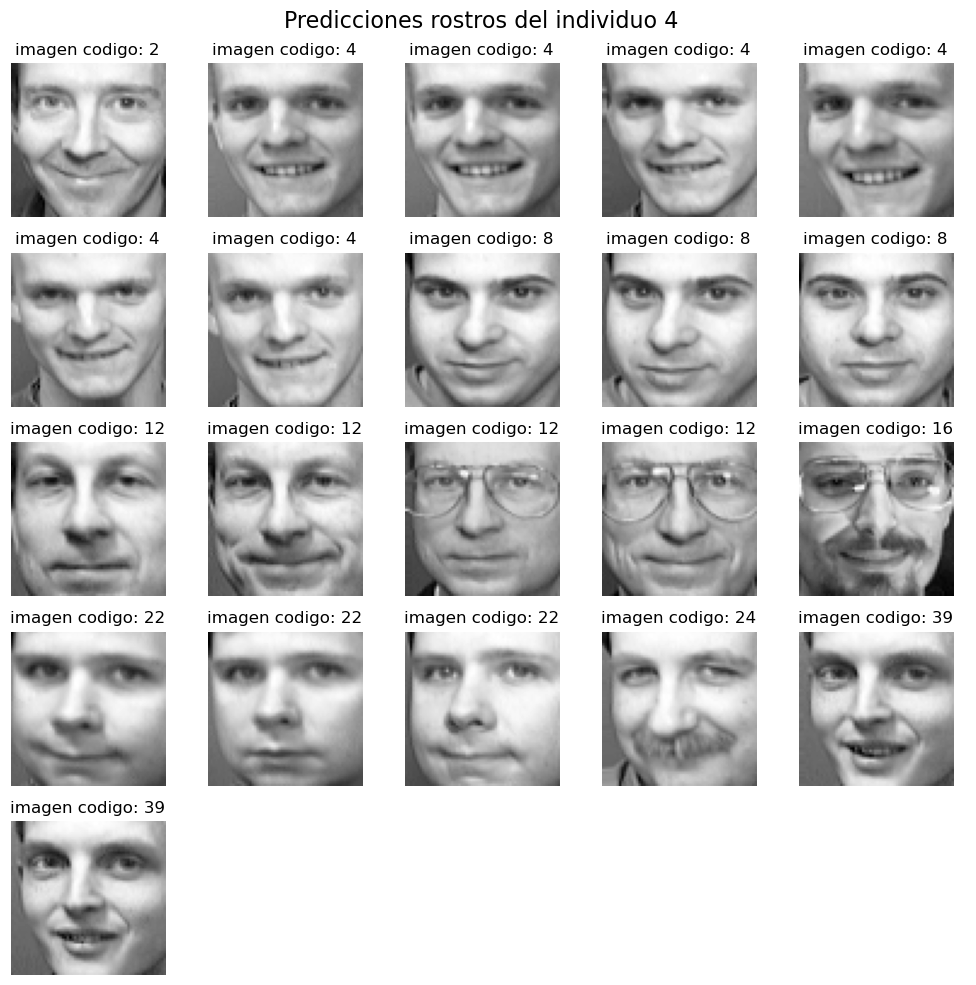

In [20]:
# cantidad de imagenes que se quieren graficar
n = 4

graficar_imagenes_individuo_original(n)

graficar_imagenes_individuo_predicho(n,"predict_kmeans")

(Utilice este espacio para describir el procedimiento, análisis y conclusiones)

#### 3.3. Usando PCA reduzca la dimensión de la matriz de predictores. Retenga el numero de componentes que explican el 95% de la varianza y vuelva a utilizar k-medias para clasificar las imágenes comentado si la precisión mejoró. 

In [21]:
data = df_images_scaled.drop(columns=columns_y)
n = min(data.shape)

model = PCA(n_components=n)
model.fit(data)
images_pca = model.transform(data)

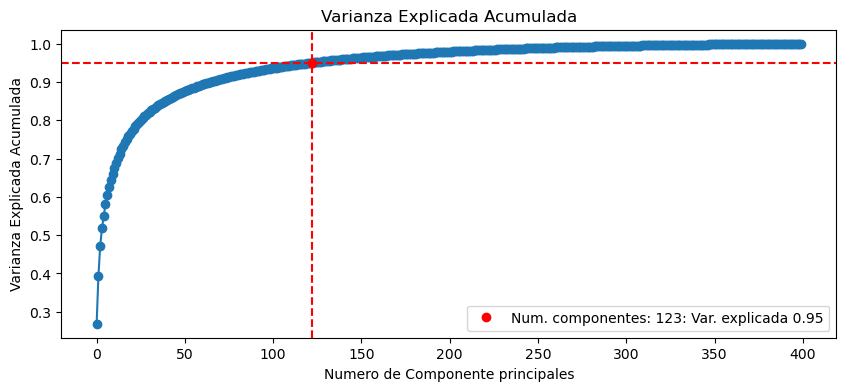

In [22]:
# Calculo de la varianza acumuladade cada componente de PCA
cumsum_var = model.explained_variance_ratio_.cumsum()
# Calculo del indice donde el valor es mayor o igual al 95% de la varianza explicada
indx = np.argmax(model.explained_variance_ratio_.cumsum()  >= 0.95)

fig, ax = plt.subplots(figsize=(10,4))

ax.plot(range(0, len(cumsum_var + 1)),cumsum_var , marker='o')
ax.plot(indx, cumsum_var[indx], 'ro', label=f'Num. componentes: {indx + 1}: Var. explicada {cumsum_var[indx]:.2f}')

ax.axhline(y = cumsum_var[indx], color = 'r', linestyle = '--')
ax.axvline(x = indx, color = 'r', linestyle = '--')

ax.set_xlabel('Numero de Componente principales')
ax.set_ylabel('Varianza Explicada Acumulada')
ax.set_title('Varianza Explicada Acumulada')
ax.legend()

In [23]:
model_95 = PCA(n_components=indx+1)
model_95.fit(data)
images_pca = model_95.transform(data)
model_95.n_components_

123

In [24]:
images_pca[0][2]

-21.8184

In [25]:
kmeans95 = KMeans(n_clusters = 40, random_state = 123, n_init=10)
kpredict95 = kmeans.fit_predict(images_pca)

c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [26]:
metodo = "kmeans_pca"
nombre_metodo = "predict_{}".format(metodo)

In [27]:
# asignacion de las predicciones
df_images_scaled[nombre_metodo] = kpredict95
# aplicar el homologador
dict_homologa_kmeans = homologar_llave_cluster_llave_dataset(df_images_scaled,nombre_metodo)
# asignacion de nuevos
df_images_scaled[nombre_metodo] = df_images_scaled[nombre_metodo].map(dict_homologa_kmeans)
columns_y = np.append(columns_y,nombre_metodo)

In [28]:
# Creacion de las variables verdaderas y las predichas para el calculo de metricas
y_true = df_images_scaled.loc[:,"target"]
y_pred = df_images_scaled.loc[:,nombre_metodo]

In [29]:

data = df_images_scaled.drop(columns=columns_y)
silhouette = silhouette_score(data, y_pred)
dict_silhouette[metodo] = silhouette
print(silhouette)

0.12625702


In [30]:
precision = precision_score(y_true, y_pred, average="micro")
dict_precision[metodo] = precision
print(precision)

0.6625


In [31]:
report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)["weighted avg"]
dict_class_report[metodo] = report
print(report)

{'precision': 0.588687094909921, 'recall': 0.6625, 'f1-score': 0.6058107614169734, 'support': 400.0}


<Axes: >

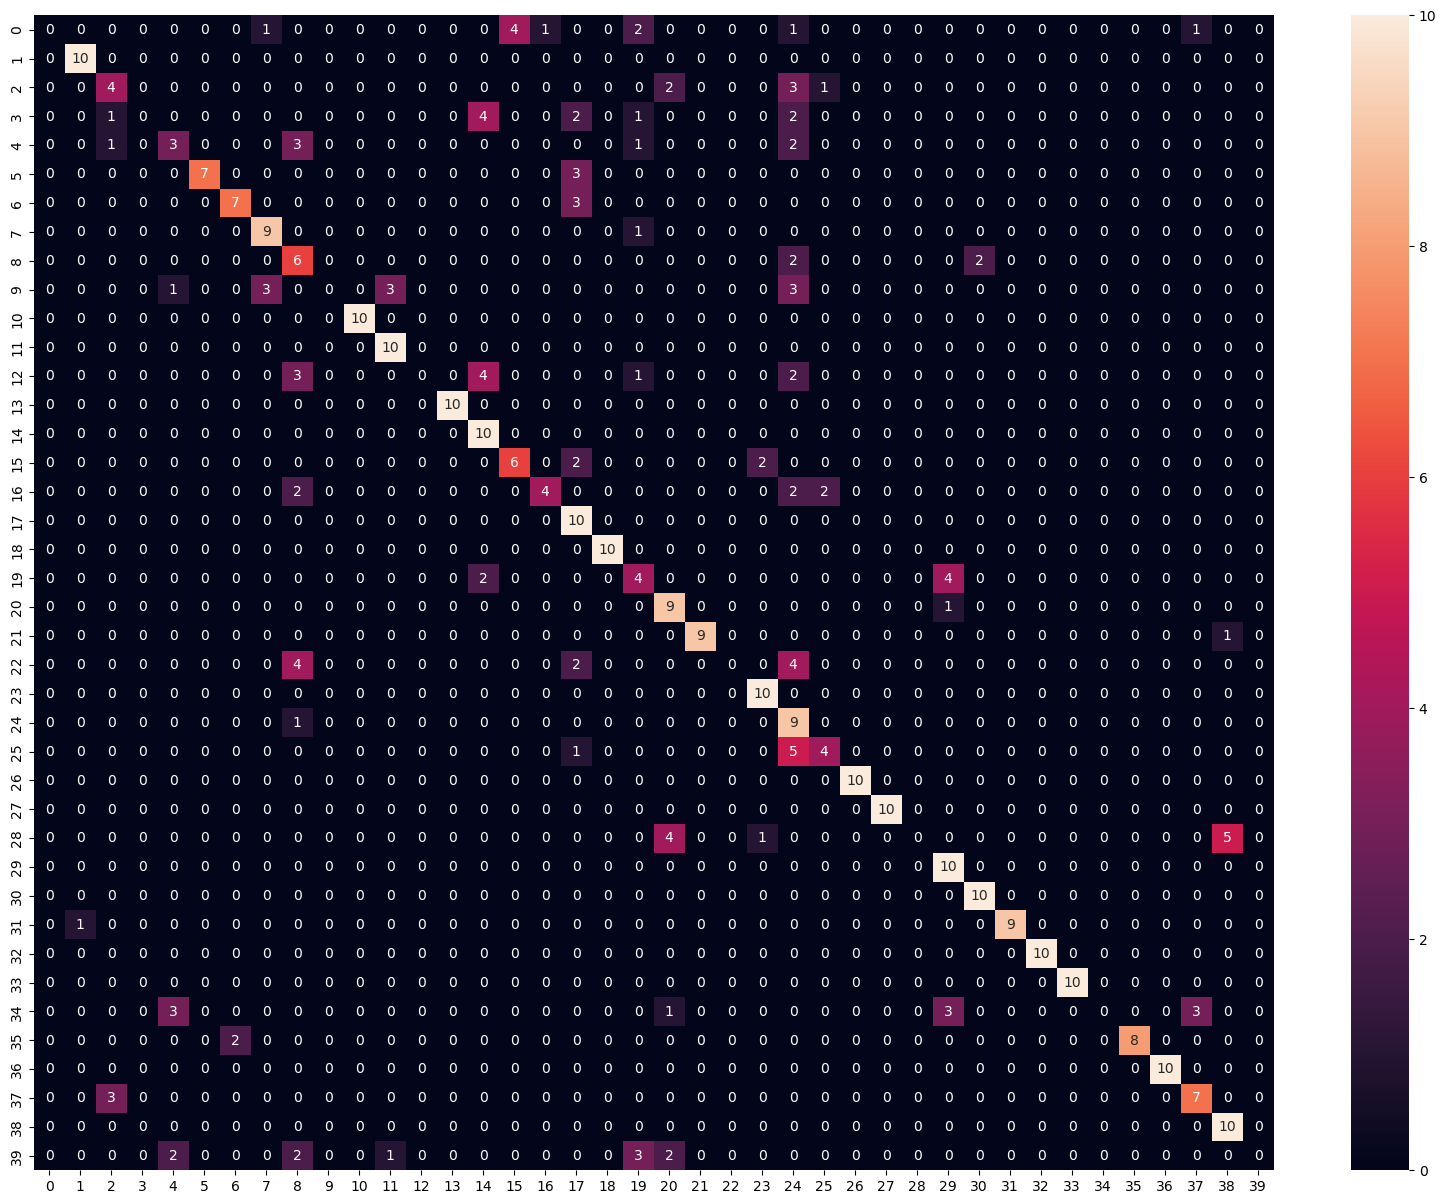

In [32]:
fig,ax = plt.subplots(figsize=(20,15))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, ax=ax)

(Utilice este espacio para describir el procedimiento, análisis y conclusiones)

#### 3.4. Utilice ahora el algoritmo por  K-medoides (use el mismo random state a los puntos anteriores), comente si mejoró la precisión total y para cada grupo de imágenes.

In [33]:
!pip install scikit-learn-extra

In [34]:
# Utilice este espacio para escribir el código.

data = df_images_scaled.drop(columns=columns_y)
data_PCA = images_pca

iter_metricas = ["euclidean","manhattan","cosine"]

arr_precision_og = []
arr_precision_95 = []

for m in iter_metricas:

    print("Scores {m} \n".format(m=m))
    print("Estandar {m} \n".format(m=m))
    # metodo para Datos Estandar
    metodo = "kmediods_{}".format(m)
    nombre_metodo = "predict_{}".format(metodo)

    columns_y = np.append(columns_y,nombre_metodo)

    Kmedoides = KMedoids(n_clusters = 40, metric = m, random_state = 123)
    Kmedoides.fit(data)


    df_images_scaled[nombre_metodo] = Kmedoides.labels_
    # aplicar el homologador
    dict_homologa_kmeans = homologar_llave_cluster_llave_dataset(df_images_scaled,nombre_metodo)
    # asignacion de nuevos
    df_images_scaled[nombre_metodo] = df_images_scaled[nombre_metodo].map(dict_homologa_kmeans)


    # Creacion de las variables verdaderas y las predichas para el calculo de metricas
    y_true = df_images_scaled.loc[:,"target"]
    y_pred = df_images_scaled.loc[:,nombre_metodo]

    data = df_images_scaled.drop(columns=columns_y)
    silhouette = silhouette_score(data, y_pred)
    dict_silhouette[metodo] = silhouette
    print(silhouette)

    precision = precision_score(y_true, y_pred, average="micro")
    dict_precision[metodo] = precision
    print(precision)

    report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)["weighted avg"]
    dict_class_report[metodo] = report
    print(report)


    # metodo para Datos PCA
    print("\n".format(m=m))
    print("PCA {m} \n".format(m=m))
    metodo = "kmediods_PCA_{}".format(m)
    nombre_metodo = "predict_{}".format(metodo)

    columns_y = np.append(columns_y,nombre_metodo)


    Kmedoides_pca = KMedoids(n_clusters = 40, metric = m, random_state = 123)
    Kmedoides_pca.fit(data_PCA)
    
    

    df_images_scaled[nombre_metodo] = Kmedoides_pca.labels_
    # aplicar el homologador
    dict_homologa_kmeans = homologar_llave_cluster_llave_dataset(df_images_scaled,nombre_metodo)
    # asignacion de nuevos
    df_images_scaled[nombre_metodo] = df_images_scaled[nombre_metodo].map(dict_homologa_kmeans)


    # Creacion de las variables verdaderas y las predichas para el calculo de metricas
    y_true = df_images_scaled.loc[:,"target"]
    y_pred = df_images_scaled.loc[:,nombre_metodo]

    data = df_images_scaled.drop(columns=columns_y)
    silhouette = silhouette_score(data, y_pred)
    dict_silhouette[metodo] = silhouette
    print(silhouette)

    precision = precision_score(y_true, y_pred, average="micro")
    dict_precision[metodo] = precision
    print(precision)

    report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)["weighted avg"]
    dict_class_report[metodo] = report
    print(report)  

Scores euclidean 

Estandar euclidean 

0.050861225
0.44
{'precision': 0.3770168584373706, 'recall': 0.44, 'f1-score': 0.37388883915169907, 'support': 400.0}


PCA euclidean 

0.038941983
0.4325
{'precision': 0.4424244608646131, 'recall': 0.4325, 'f1-score': 0.3882974548727817, 'support': 400.0}
Scores manhattan 

Estandar manhattan 

0.04134248
0.47
{'precision': 0.4200209940128671, 'recall': 0.47, 'f1-score': 0.4020770760895486, 'support': 400.0}


PCA manhattan 

-0.032074556
0.365
{'precision': 0.28354106167291826, 'recall': 0.365, 'f1-score': 0.29253699878746586, 'support': 400.0}
Scores cosine 

Estandar cosine 

0.033369657
0.475
{'precision': 0.42277464147433186, 'recall': 0.475, 'f1-score': 0.40965092511945556, 'support': 400.0}


PCA cosine 

0.04046122
0.4825
{'precision': 0.44707521843551246, 'recall': 0.4825, 'f1-score': 0.42821611237007784, 'support': 400.0}


In [35]:
df_images_scaled.head().columns.values[-60:]
#["kmediods_cosine"]

array([4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055,
       4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066,
       4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077,
       4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088,
       4089, 4090, 4091, 4092, 4093, 4094, 4095, 'target',
       'predict_kmeans', 'predict_kmeans_pca',
       'predict_kmediods_euclidean', 'predict_kmediods_PCA_euclidean',
       'predict_kmediods_manhattan', 'predict_kmediods_PCA_manhattan',
       'predict_kmediods_cosine', 'predict_kmediods_PCA_cosine'],
      dtype=object)

In [36]:
dc = classification_report(y_true,df_images_scaled["predict_kmeans"],output_dict=True)
dc = {k: v["precision"] for k,v in dc.items() if isinstance(v, dict)}
df_comparar = pd.DataFrame.from_dict(dc,orient="index")


dc = classification_report(y_true,df_images_scaled["predict_kmediods_cosine"],output_dict=True)
dc = {k: v["precision"] for k,v in dc.items() if isinstance(v, dict)}
df_comparar = pd.concat([df_comparar,pd.DataFrame.from_dict(dc,orient="index")],axis=1)
df_comparar.columns = ["predict_kmeans","predict_kmediods_cosine"]
df_comparar["diff"] = df_comparar["predict_kmeans"] - df_comparar["predict_kmediods_cosine"]
df_comparar

c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paul\anaconda3\envs\tf\li

,predict_kmeans,predict_kmediods_cosine,diff
0,0.600000,0.750000,-0.150000
1,1.000000,0.666667,0.333333
2,0.375000,1.000000,-0.625000
3,0.000000,1.000000,-1.000000
4,0.285714,0.428571,-0.142857
5,1.000000,0.333333,0.666667
6,0.000000,0.315789,-0.315789
7,0.727273,0.428571,0.298701
8,0.388889,0.875000,-0.486111
9,0.173913,0.857143,-0.683230


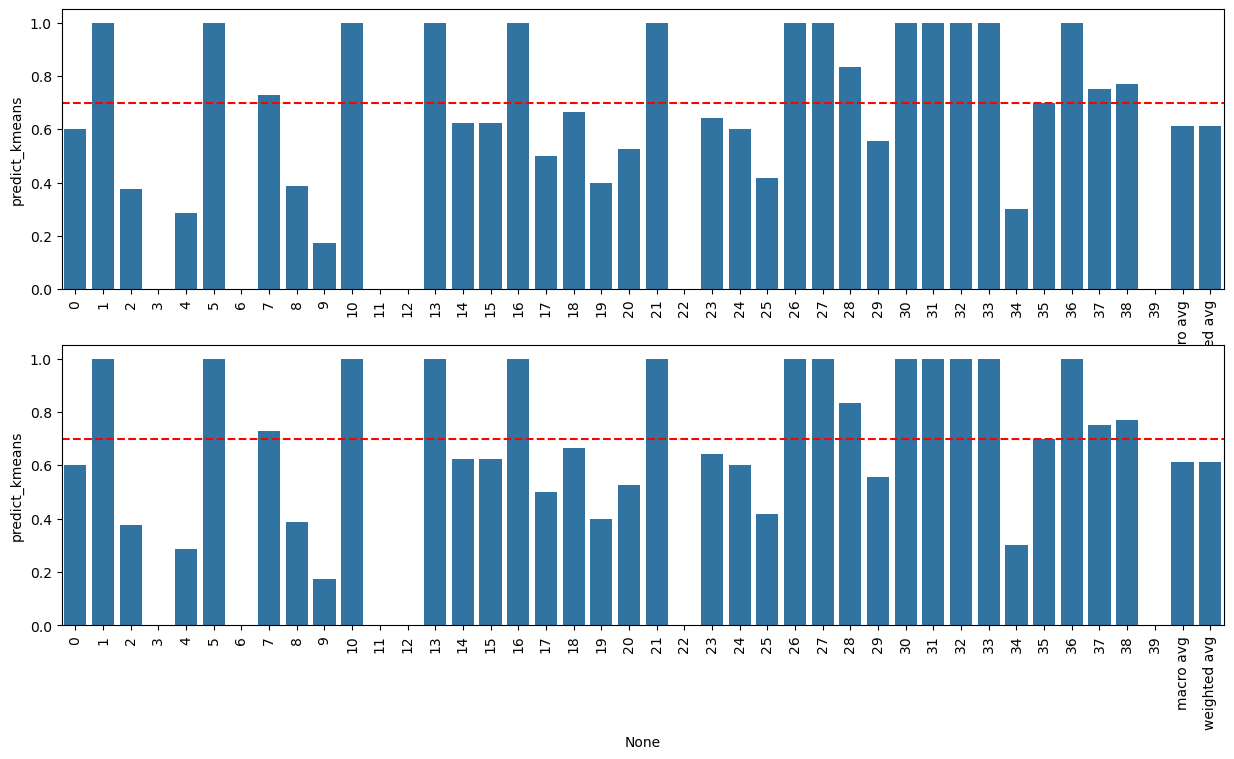

In [37]:
fig, ax = plt.subplots(2,1,figsize=(15,2*4))
axs = ax.flatten()

sns.barplot(data=df_comparar, x=df_comparar.index, y = "predict_kmeans",ax=ax[0])
ax[0].tick_params(axis='x', rotation=90)
ax[0].axhline(0.7, linestyle = "--", color = "r", label="umbral elegido")

sns.barplot(data=df_comparar, x=df_comparar.index, y = "predict_kmeans",ax=ax[1])
ax[1].tick_params(axis='x', rotation=90)
ax[1].axhline(0.7, linestyle = "--", color = "r", label="umbral elegido")

(Utilice este espacio para describir el procedimiento, análisis y conclusiones)

### 4. Número de clusters óptimo

En el punto anteriores utilizamos nuestro conocimiento previo sobre los datos para elegir el número de clusters. En este punto, verifique si 40 es realmente el número de cluster que usted elegiría según los criterios estudiados en los cuadernos teóricos. Discuta los resultados obtenidos.

In [38]:
data.shape

(400, 4096)

In [39]:
test = model.fit_transform(data)
test[0][1]

-2.173959

In [40]:
test = model.fit(data)
test = model.transform(data)
test[0][1]

-2.173931

In [41]:
test = model_95.fit_transform(data)
test[0][1]

-2.1739326

In [42]:
test = model_95.fit(data)
test = model_95.transform(data)
test[0][1]

-2.1739511

In [43]:
data_PCA[0][1]

-2.1739833

In [44]:
arr_inertia = []
arr_silhouete = []

arr_iteracion = np.arange(2,400,50)

for i in arr_iteracion:

    print(i)
    
    metodo = "kmeans_n{}".format(i)
    nombre_metodo = "predict_{}".format(metodo)

    #data = df_images_scaled.drop(columns=columns_y)
    data_iter = data_PCA

    kmeans_iter = KMeans(n_clusters = i, random_state = 123, n_init=10)
    kmeans_iter.fit(data_iter)
    kpredict = kmeans_iter.predict(data_iter)

    arr_inertia.append(kmeans_iter.inertia_)


    df_images_scaled[nombre_metodo] = kpredict
    # aplicar el homologador
    dict_homologa_kmeans = homologar_llave_cluster_llave_dataset(df_images_scaled,nombre_metodo)
    # asignacion de nuevos
    df_images_scaled[nombre_metodo] = df_images_scaled[nombre_metodo].map(dict_homologa_kmeans)

    columns_y = np.append(columns_y,nombre_metodo)


    # Creacion de las variables verdaderas y las predichas para el calculo de metricas
    y_true = df_images_scaled.loc[:,"target"]
    y_pred = df_images_scaled.loc[:,nombre_metodo]


    # silhouette debe calcularse con el predict original y no con la homologacion, o si no da una metrica incorrecta
    silhouette = silhouette_score(data_iter, kpredict)
    dict_silhouette[metodo] = silhouette
    arr_silhouete.append(silhouette)
    print(silhouette)

    precision = precision_score(y_true, y_pred, average="micro")
    dict_precision[metodo] = precision

    print(precision)

    report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)["weighted avg"]
    dict_class_report[metodo] = report
    print(report)

2


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.17543294
0.05
{'precision': 0.002896535743251072, 'recall': 0.05, 'f1-score': 0.0054370339685169845, 'support': 400.0}
52


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.19530356
0.7425
{'precision': 0.7080970048529192, 'recall': 0.7425, 'f1-score': 0.7054638517479664, 'support': 400.0}
102


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.24955048
0.9075
{'precision': 0.918781426906427, 'recall': 0.9075, 'f1-score': 0.9043992044658353, 'support': 400.0}
152


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.26189435
0.9575
{'precision': 0.965031635031635, 'recall': 0.9575, 'f1-score': 0.9583433750034235, 'support': 400.0}
202


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.23800476
0.9825
{'precision': 0.9842424242424244, 'recall': 0.9825, 'f1-score': 0.9824244322928533, 'support': 400.0}
252


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.19356777
1.0
{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 400.0}
302


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.148627
1.0
{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 400.0}
352


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.085412845
1.0
{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 400.0}


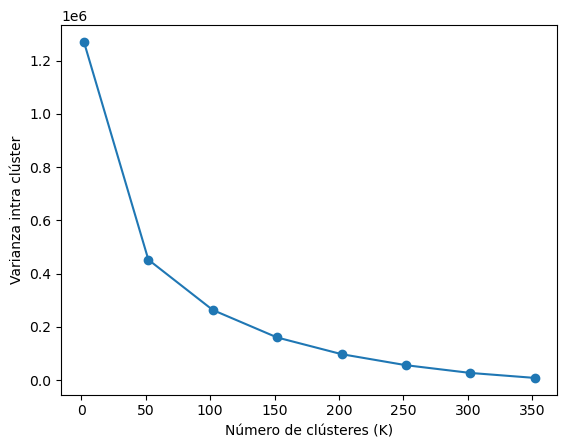

In [45]:
plt.plot(arr_iteracion, arr_inertia, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

In [46]:
np.array(arr_silhouete) - np.array([0.17536747, 0.20049396, 0.26431844, 0.26040334, 0.23851627, 0.19894241, 0.14620095, 0.081336536])

array([ 6.54653571e-05, -5.19040070e-03, -1.47679633e-02,  1.49100528e-03,
       -5.11511046e-04, -5.37464226e-03,  2.42604807e-03,  4.07630902e-03])

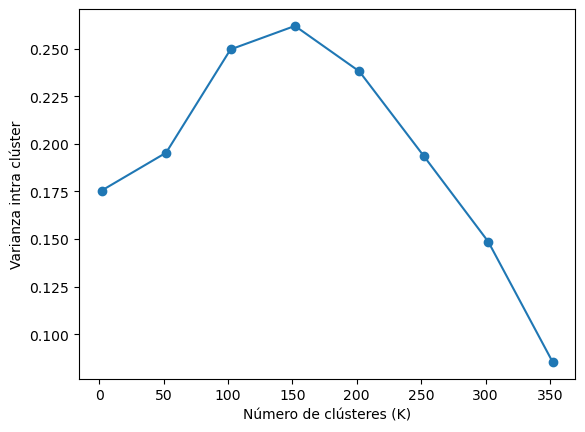

In [47]:
#arr_silhouete = list({k:v for k,v in dict_silhouette.items() if "kmeans_n" in k}.values())

plt.plot(arr_iteracion, arr_silhouete , marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

<Axes: xlabel='0', ylabel='index'>

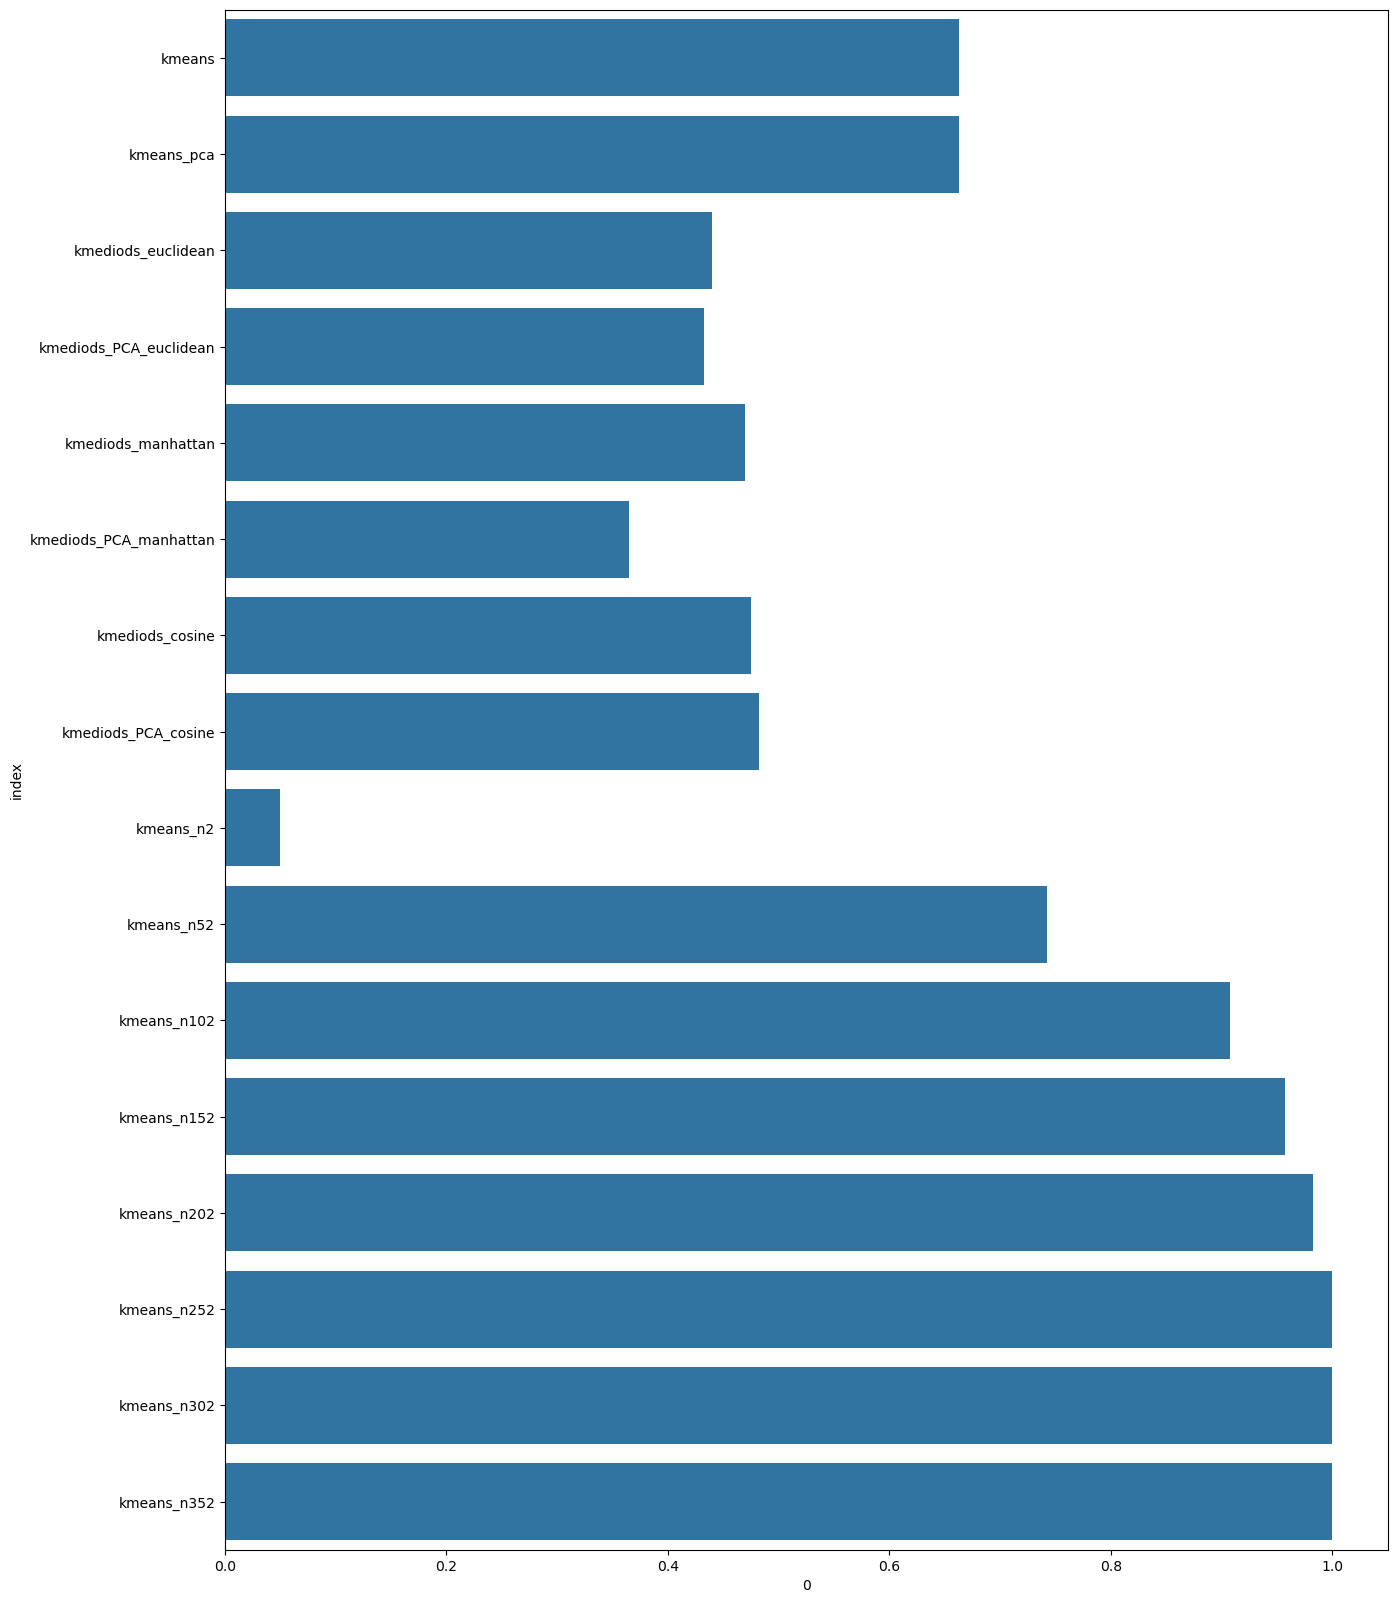

In [48]:
pd.DataFrame.from_dict(dict_precision,orient="index").reset_index()

fig, ax = plt.subplots(figsize=(15,20))
sns.barplot(data=pd.DataFrame.from_dict(dict_precision,orient="index").reset_index(), y="index", x=0)

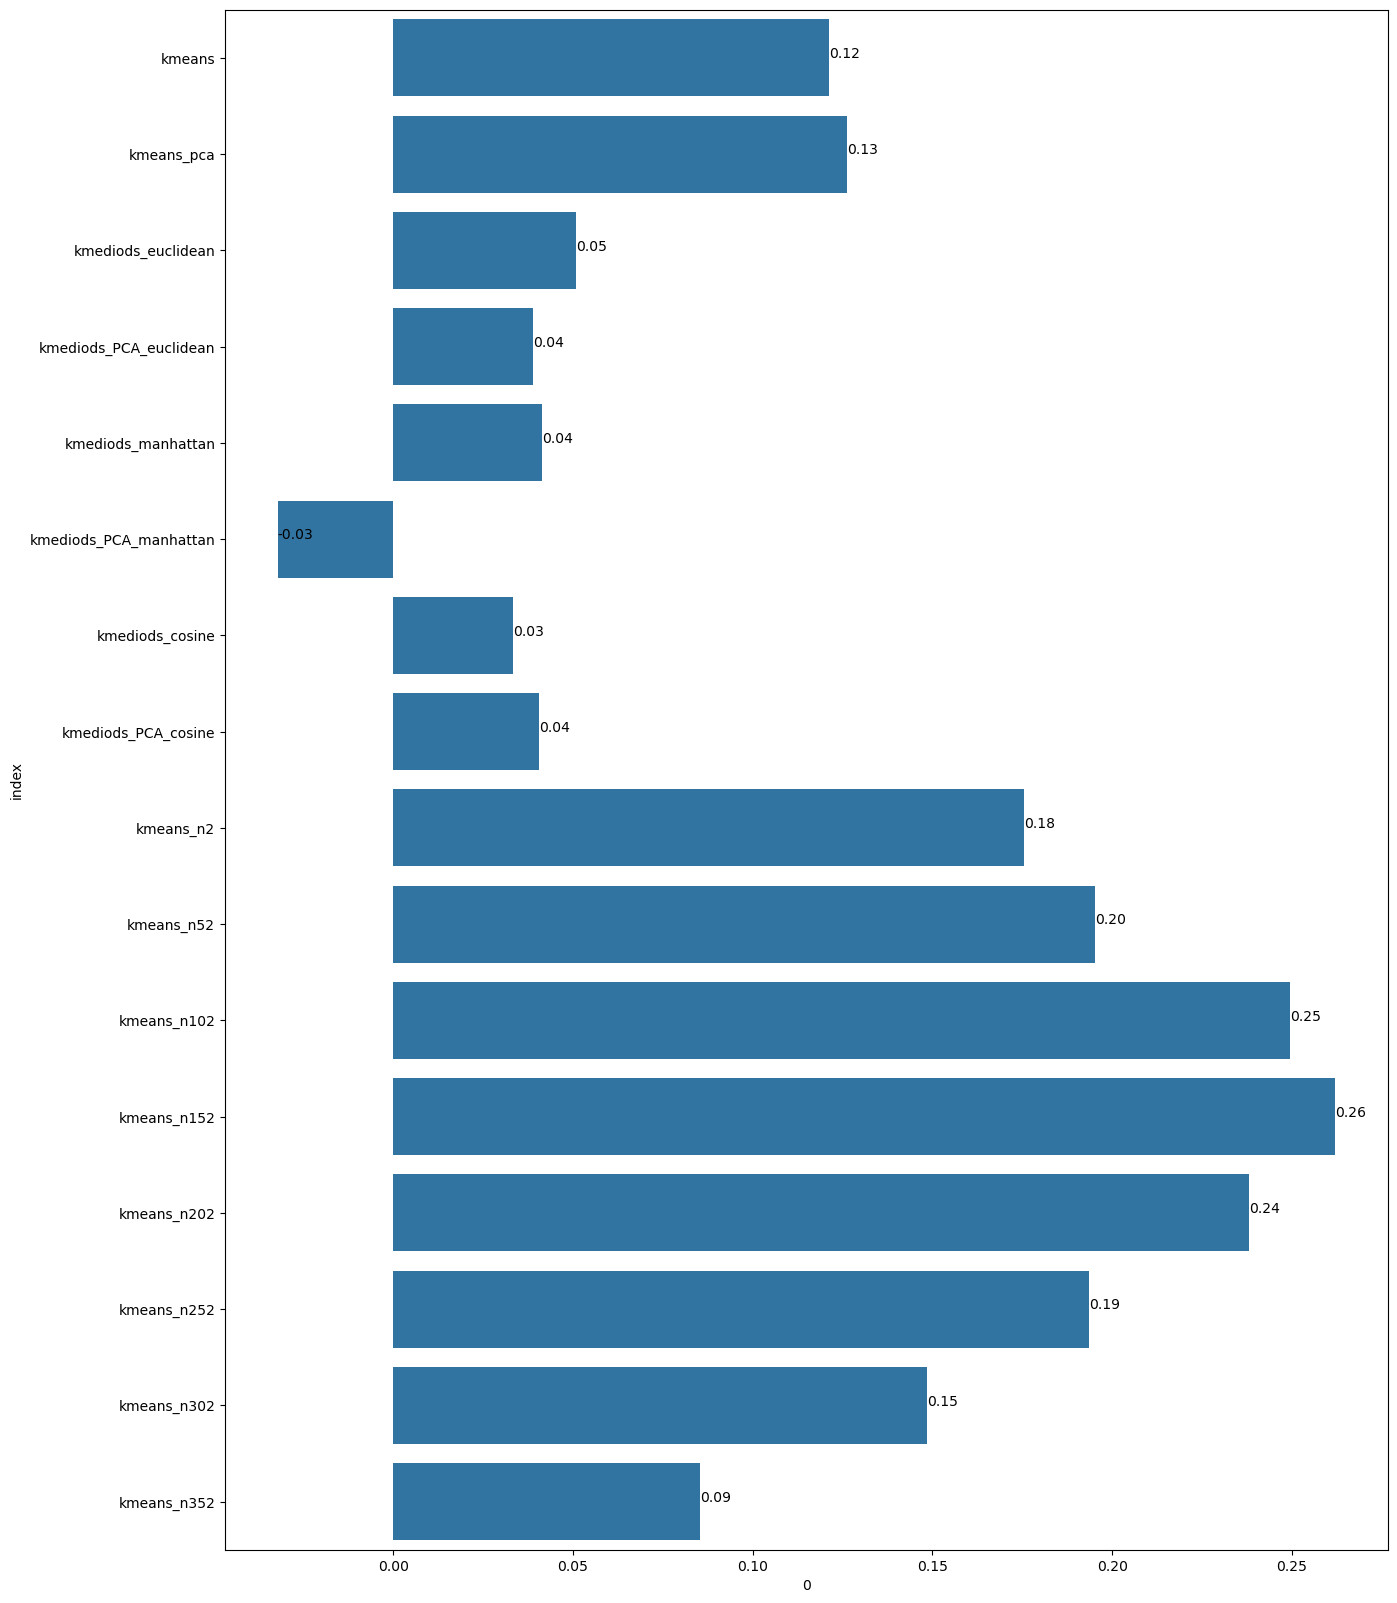

In [49]:
#pd.DataFrame.from_dict(dict_silhouette,orient="index").reset_index()
df = pd.DataFrame.from_dict(dict_silhouette,orient="index").reset_index()


fig, ax = plt.subplots(figsize=(15,20))
sns.barplot(data=df, y="index", x=0)

for index, value in enumerate(df[0]):
    ax.text(value, index, f'{value:.2f}', color='black', ha="left")

<Axes: xlabel='0', ylabel='index'>

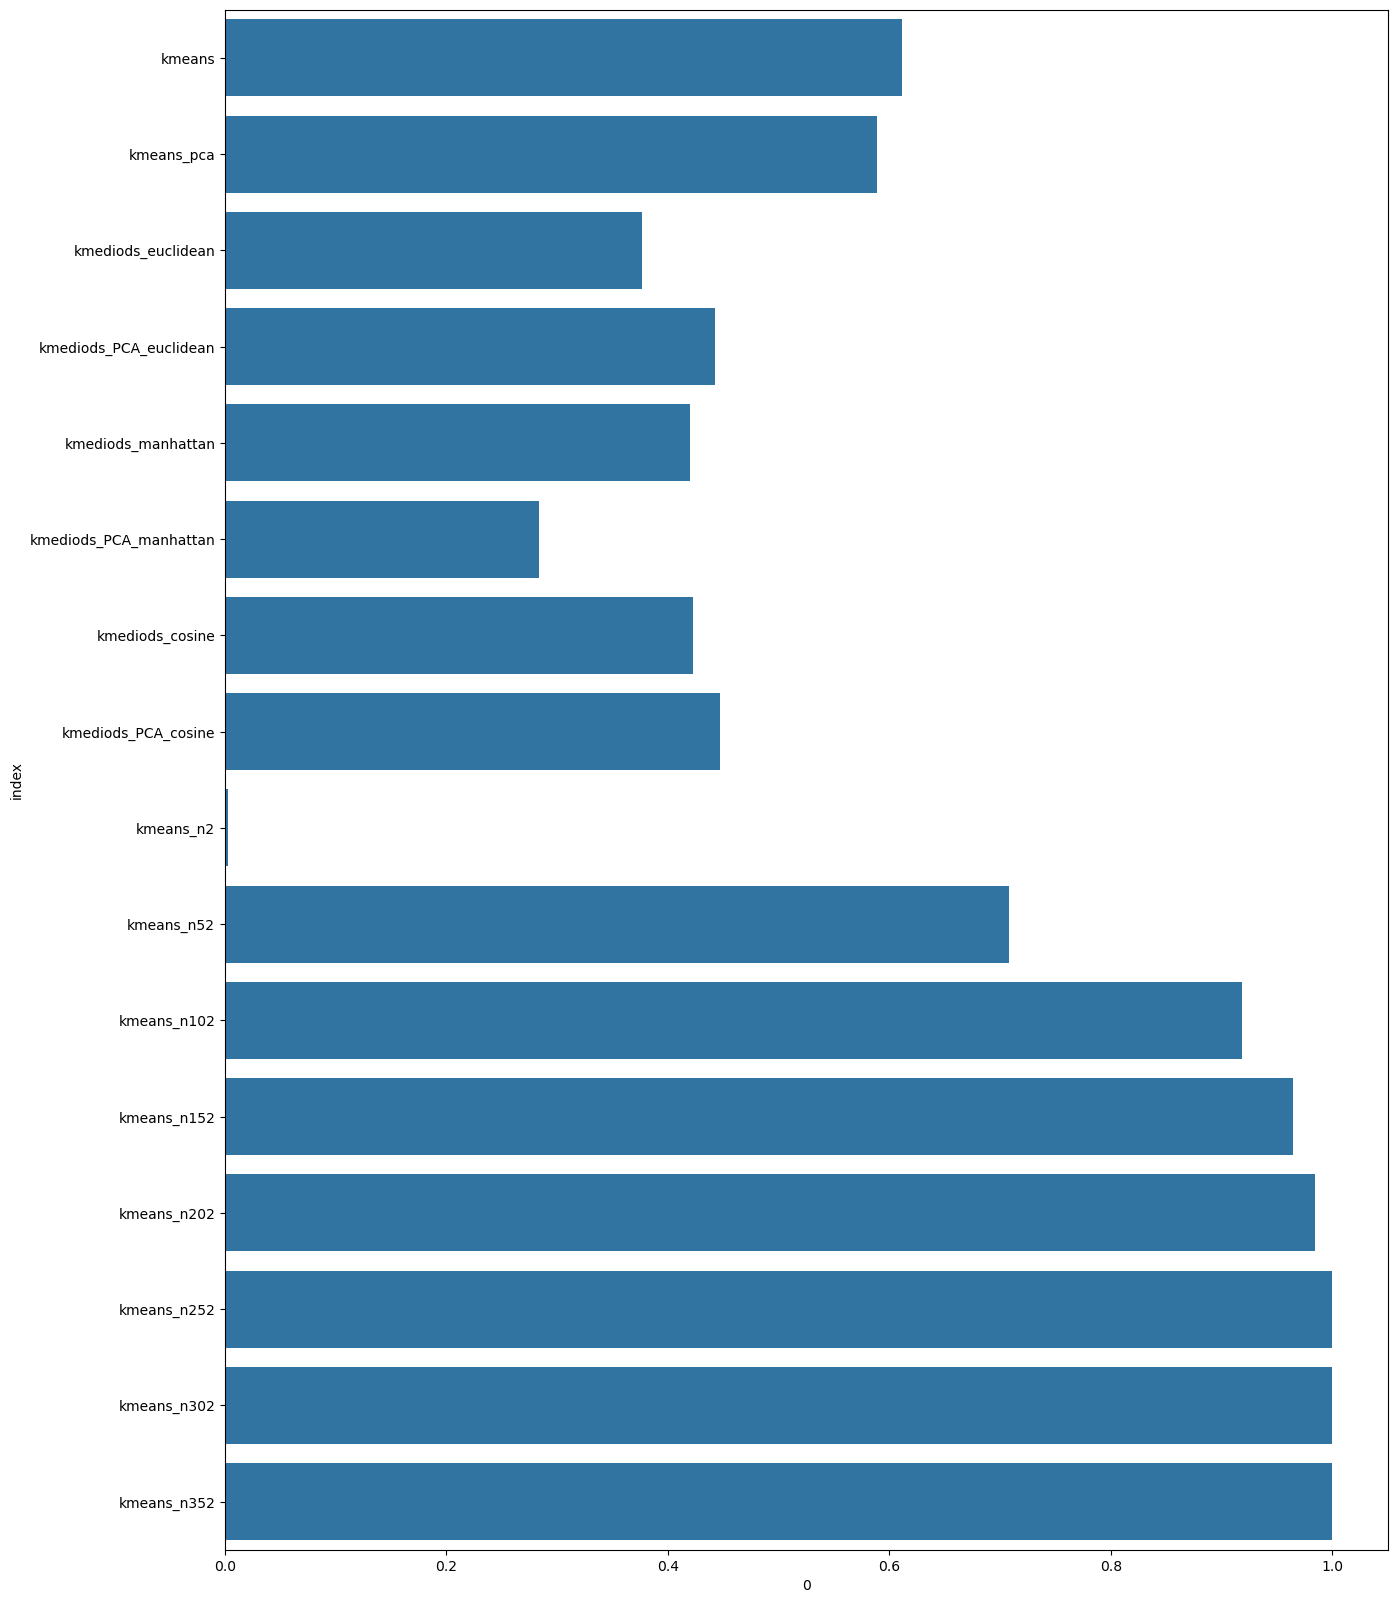

In [50]:
fig, ax = plt.subplots(figsize=(15,20))
sns.barplot(data=pd.DataFrame.from_dict({k: v["precision"] for k, v in dict_class_report.items()},orient="index").reset_index(), y="index", x=0)


(Utilice este espacio para describir el procedimiento, análisis y conclusiones)